# Optimal Savings I: Value Function Iteration

-----

#### John Stachurski

#### Prepared for the CBC Workshop (May 2024)

-----

Uncomment if necessary:

In [1]:
#!pip install quantecon

We will use the following imports:

In [2]:
import quantecon as qe
import numpy as np
import jax
import jax.numpy as jnp
from collections import namedtuple
import matplotlib.pyplot as plt
import time

Let's check available GPUs

In [3]:
!nvidia-smi

Fri May 10 15:19:28 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        Off |   00000000:3E:00.0 Off |                  N/A |
| 30%   31C    P8             26W /  320W |       9MiB /  10240MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

/home/john/anaconda3/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


We'll use 64 bit floats to gain extra precision.

In [4]:
jax.config.update("jax_enable_x64", True)

## Overview

We consider an optimal savings problem with CRRA utility and budget constraint

$$ 
    W_{t+1} + C_t \leq R W_t + Y_t 
$$

where

* $C_t$ is consumption and $C_t \geq 0$,
* $W_t$ is wealth and $W_t \geq 0$,
* $R > 0$ is a gross rate of return, and
* $(Y_t)$ is labor income.

We assume below that labor income is a discretized AR(1) process.

The Bellman equation is

$$   
    v(w) = \max_{0 \leq w' \leq Rw + y}
    \left\{
        u(Rw + y - w') + β \sum_{y'} v(w', y') Q(y, y') 
    \right\}
$$

where

$$
    u(c) = \frac{c^{1-\gamma}}{1-\gamma} 
$$

In the code we use the function

$$   
    B((w, y), w', v) = u(Rw + y - w') + β \sum_{y'} v(w', y') Q(y, y'). 
$$

to represent the (unmaximized) right hand side of the Bellman equation.



## Starting with NumPy

Let's start with a standard NumPy version running on the CPU.

Starting with this traditional approach will allow us to record the speed gain
associated with switching to JAX.

(NumPy operations are similar to MATLAB operations, so this also serves as a
rough comparison with MATLAB.)



### Functions and operators

We start with a namedtuple to store parameters and arrays

In [5]:
Model = namedtuple('Model', ('β', 'R', 'γ', 'w_grid', 'y_grid', 'Q'))

The following function contains default parameters and returns a namedtuple
that contain the key computational components of the model.

In [6]:
def create_consumption_model(R=1.01,                    # Gross interest rate
                             β=0.95,                    # Discount factor
                             γ=2.0,                     # CRRA parameter
                             w_min=0.01,                # Min wealth
                             w_max=15.0,                # Max wealth
                             w_size=200,                # Grid size
                             ρ=0.9, ν=0.1, y_size=100): # Income parameters
    """
    A function that takes in parameters and returns parameters and grids 
    for the optimal savings problem.
    """
    # Build grids and transition probabilities
    w_grid = np.linspace(w_min, w_max, w_size)
    mc = qe.tauchen(n=y_size, rho=ρ, sigma=ν)
    y_grid, Q = np.exp(mc.state_values), mc.P
    # Pack and return
    return Model(β, R, γ, w_grid, y_grid, Q)

To produce efficient NumPy code, we will use a vectorized approach. 

The first step is to create the right hand side of the Bellman equation as a
multi-dimensional array with dimensions over all states and controls.

In [7]:
def B(v, model):
    """
    A vectorized version of the right-hand side of the Bellman equation
    (before maximization), which is a 3D array representing

        B(w, y, w′) = u(Rw + y - w′) + β Σ_y′ v(w′, y′) Q(y, y′)

    for all (w, y, w′).
    """

    # Unpack
    β, R, γ, w_grid, y_grid, Q = model
    w_size, y_size = len(w_grid), len(y_grid)

    # Compute current rewards r(w, y, wp) as array r[i, j, ip]
    w  = np.reshape(w_grid, (w_size, 1, 1))    # w[i]   ->  w[i, j, ip]
    y  = np.reshape(y_grid, (1, y_size, 1))    # z[j]   ->  z[i, j, ip]
    wp = np.reshape(w_grid, (1, 1, w_size))    # wp[ip] -> wp[i, j, ip]
    c = R * w + y - wp

    # Calculate continuation rewards at all combinations of (w, y, wp)
    v = np.reshape(v, (1, 1, w_size, y_size))  # v[ip, jp] -> v[i, j, ip, jp]
    Q = np.reshape(Q, (1, y_size, 1, y_size))  # Q[j, jp]  -> Q[i, j, ip, jp]
    EV = np.sum(v * Q, axis=3)                 # sum over last index jp

    # Compute the right-hand side of the Bellman equation
    return np.where(c > 0, c**(1-γ)/(1-γ) + β * EV, -np.inf)

Here are two functions we need for value function iteration.

The first is the Bellman operator.

The second computes a $v$-greedy policy given $v$ (i.e., the policy that
maximizes the right-hand side of the Bellman equation.)

In [8]:
def T(v, model):
    "The Bellman operator."
    return np.max(B(v, model), axis=2)

def get_greedy(v, model):
    "Computes a v-greedy policy, returned as a set of indices."
    return np.argmax(B(v, model), axis=2)

### Value function iteration

Here's a routine that performs value function iteration.

In [9]:
def value_function_iteration(model, max_iter=10_000, tol=1e-5):
    β, R, γ, w_grid, y_grid, Q = model
    w_size, y_size = len(w_grid), len(y_grid)
    v = np.zeros((w_size, y_size))

    i, error = 0, tol + 1
    while error > tol and i < max_iter:
        v_new = T(v, model)
        error = np.max(np.abs(v_new - v))
        i += 1
        v = v_new
    return v, get_greedy(v, model)

Now we create an instance, unpack it, and test how long it takes to solve the
model.

In [10]:
model = create_consumption_model()
β, R, γ, w_grid, y_grid, Q = model
w_size, y_size = len(w_grid), len(y_grid)

print("Starting VFI on the CPU using NumPy.")
start_time = time.time()
v_star, σ_star = value_function_iteration(model)
numpy_elapsed = time.time() - start_time
print(f"VFI completed in {numpy_elapsed} seconds.")

Starting VFI on the CPU using NumPy.
VFI completed in 6.235893487930298 seconds.


Here's a plot of the policy function.

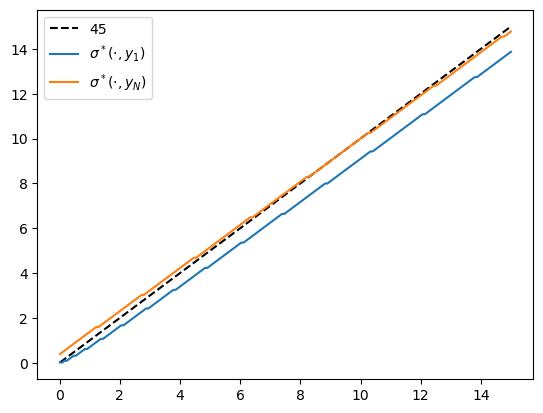

In [11]:
fig, ax = plt.subplots()
ax.plot(w_grid, w_grid, "k--", label="45")
ax.plot(w_grid, w_grid[σ_star[:, 1]], label="$\\sigma^*(\cdot, y_1)$")
ax.plot(w_grid, w_grid[σ_star[:, -1]], label="$\\sigma^*(\cdot, y_N)$")
ax.legend()
plt.show()

## Switching to JAX

To switch over to JAX, we change `np` to `jnp` throughout and add some
`jax.jit` requests.


### Functions and operators

We redefine `create_consumption_model` to produce JAX arrays.

In [12]:
def create_consumption_model(R=1.01,                    # Gross interest rate
                             β=0.98,                    # Discount factor
                             γ=2,                       # CRRA parameter
                             w_min=0.01,                # Min wealth
                             w_max=5.0,                 # Max wealth
                             w_size=150,                # Grid size
                             ρ=0.9, ν=0.1, y_size=100): # Income parameters
    """
    A function that takes in parameters and returns parameters and grids 
    for the optimal savings problem.
    """
    w_grid = jnp.linspace(w_min, w_max, w_size)
    mc = qe.tauchen(n=y_size, rho=ρ, sigma=ν)
    y_grid, Q = jnp.exp(mc.state_values), jax.device_put(mc.P)
    return Model(β, R, γ, w_grid, y_grid, Q)

The right hand side of the Bellman equation is the same as the NumPy version
after switching `np` to `jnp`.

In [13]:
@jax.jit
def B(v, model):
    """
    A vectorized version of the right-hand side of the Bellman equation
    (before maximization), which is a 3D array representing

        B(w, y, w′) = u(Rw + y - w′) + β Σ_y′ v(w′, y′) Q(y, y′)

    for all (w, y, w′).
    """

    # Unpack
    β, R, γ, w_grid, y_grid, Q = model
    w_size, y_size = len(w_grid), len(y_grid)

    # Compute current rewards r(w, y, wp) as array r[i, j, ip]
    w  = jnp.reshape(w_grid, (w_size, 1, 1))    # w[i]   ->  w[i, j, ip]
    y  = jnp.reshape(y_grid, (1, y_size, 1))    # z[j]   ->  z[i, j, ip]
    wp = jnp.reshape(w_grid, (1, 1, w_size))    # wp[ip] -> wp[i, j, ip]
    c = R * w + y - wp

    # Calculate continuation rewards at all combinations of (w, y, wp)
    v = jnp.reshape(v, (1, 1, w_size, y_size))  # v[ip, jp] -> v[i, j, ip, jp]
    Q = jnp.reshape(Q, (1, y_size, 1, y_size))  # Q[j, jp]  -> Q[i, j, ip, jp]
    EV = jnp.sum(v * Q, axis=3)                 # sum over last index jp

    # Compute the right-hand side of the Bellman equation
    return jnp.where(c > 0, c**(1-γ)/(1-γ) + β * EV, -jnp.inf)

Some readers might be concerned that we are creating high dimensional arrays,
leading to inefficiency.

Could they be avoided by more careful vectorization?

In fact this is not necessary: this function will be JIT-compiled by JAX, and
the JIT compiler will optimize compiled code to minimize memory use.

The Bellman operator $T$ can be implemented by

In [14]:
@jax.jit
def T(v, model):
    "The Bellman operator."
    return jnp.max(B(v, model), axis=2)

The next function computes a $v$-greedy policy given $v$ (i.e., the policy that
maximizes the right-hand side of the Bellman equation.)

In [15]:
@jax.jit
def get_greedy(v, model):
    "Computes a v-greedy policy, returned as a set of indices."
    return jnp.argmax(B(v, model), axis=2)

### Successive approximation

Now we define a solver that implements VFI.

We could use the one we built for NumPy above, after changing `np` to `jnp`.

Alternatively, we can push a bit harder and write a compiled version using
`jax.lax.while_loop`.

This will give us just a bit more speed.

The first step is to write a compiled successive approximation routine that
performs fixed point iteration on some given function `T`.

In [16]:
def successive_approx_jax(T,                     # Operator (callable)
                          v_0,                   # Initial condition                
                          tolerance=1e-6,        # Error tolerance
                          max_iter=10_000):      # Max iteration bound
    def body_fun(state):
        i, v, error = state
        v_new = T(v)
        error = jnp.max(jnp.abs(v_new - v))
        return i + 1, v_new, error

    def cond_fun(state):
        i, v, error = state
        return jnp.logical_and(error > tolerance, i < max_iter)

    initial_state = 1, v_0, tolerance + 1
    i, x, error = jax.lax.while_loop(cond_fun, body_fun, initial_state)
    return x

successive_approx_jax = jax.jit(successive_approx_jax, static_argnums=(0,))

Our value function iteration routine calls `successive_approx_jax` while passing
in the Bellman operator.

In [17]:
def value_function_iteration(model, tol=1e-5):
    β, R, γ, w_grid, y_grid, Q = model
    w_size, y_size = len(w_grid), len(y_grid)
    v_0 = jnp.zeros((w_size, y_size))
    v_star = successive_approx_jax(lambda v: T(v, model), v_0, tolerance=tol)
    return v_star, get_greedy(v_star, model)

### Timing

Let's create an instance for the test

In [18]:
model = create_consumption_model()

Let's see how long it takes to solve this model.

In [19]:
print("Starting VFI using JAX / vectorization.")
start_time = time.time()
v_star_jax, σ_star_jax = value_function_iteration(model)
jax_elapsed = time.time() - start_time
print(f"VFI completed in {jax_elapsed} seconds.")

Starting VFI using JAX / vectorization.
VFI completed in 0.4175076484680176 seconds.


One more time:

In [20]:
print("Starting VFI on using JAX / vectorization.")
start_time = time.time()
v_star_jax, σ_star_jax = value_function_iteration(model)
jax_elapsed = time.time() - start_time
print(f"VFI completed in {jax_elapsed} seconds.")

Starting VFI on using JAX / vectorization.
VFI completed in 0.18111276626586914 seconds.


The relative speed gain is

In [21]:
print(f"Relative speed gain = {numpy_elapsed / jax_elapsed}")

Relative speed gain = 34.43099907588048


## Switching to vmap

For this simple optimal savings problem, direct vectorization is relatively easy.

In particular, it's straightforward to express the right hand side of the
Bellman equation as an array that stores evaluations of the function at every
state and control.

For more complex models direct vectorization can be much harder.

For this reason, it helps to have another approach to fast JAX implementations
up our sleeves.

Here's a version that 

1. writes the right hand side of the Bellman operator as a function of individual states and controls, and 
1. applies `jax.vmap` on the outside to achieve a parallelized solution.

First let's rewrite `B`

In [22]:
def B(v, model, i, j, ip):
    """
    The right-hand side of the Bellman equation before maximization, which takes
    the form

        B(w, y, w′) = u(Rw + y - w′) + β Σ_y′ v(w′, y′) Q(y, y′)

    The indices are (i, j, ip) -> (w, y, w′).
    """
    β, R, γ, w_grid, y_grid, Q = model
    w, y, wp  = w_grid[i], y_grid[j], w_grid[ip]
    c = R * w + y - wp
    EV = jnp.sum(v[ip, :] * Q[j, :]) 
    return jnp.where(c > 0, c**(1-γ)/(1-γ) + β * EV, -jnp.inf)

Now we successively apply `vmap` to simulate nested loops.

In [23]:
B = jax.vmap(B, in_axes=(None, None, None, None, 0))
B = jax.vmap(B, in_axes=(None, None, None, 0,    None))
B = jax.vmap(B, in_axes=(None, None, 0,    None, None))

Here's the Bellman operator and the `get_greedy` functions for the `vmap` case.

In [24]:
@jax.jit
def T_vmap(v, model):
    "The Bellman operator."
    β, R, γ, w_grid, y_grid, Q = model
    w_size, y_size = len(w_grid), len(y_grid)
    w_indices, y_indices = jnp.arange(w_size), jnp.arange(y_size)
    B_values = B(v, model, w_indices, y_indices, w_indices)
    return jnp.max(B_values, axis=-1)


@jax.jit
def get_greedy_vmap(v, model):
    "Computes a v-greedy policy, returned as a set of indices."
    β, R, γ, w_grid, y_grid, Q = model
    w_size, y_size = len(w_grid), len(y_grid)
    w_indices, y_indices = jnp.arange(w_size), jnp.arange(y_size)
    B_values = B_vmap(v, model, w_indices, y_indices, w_indices)
    return jnp.argmax(B_values, axis=-1)


Here's the iteration routine.

In [25]:
def value_iteration_vmap(model, tol=1e-5):
    β, R, γ, w_grid, y_grid, Q = model
    w_size, y_size = len(w_grid), len(y_grid)
    vz = jnp.zeros((w_size, y_size))
    _T = lambda v: T_vmap(v, model)
    v_star = successive_approx_jax(_T, vz, tolerance=tol)
    return v_star, get_greedy(v_star, model)

Let's see how long it takes to solve the model using the `vmap` method.

In [26]:
print("Starting VFI using JAX / vmap.")
start_time = time.time()
v_star_vmap, σ_star_vmap = value_iteration_vmap(model)
jax_vmap_elapsed = time.time() - start_time
print(f"VFI completed in {jax_vmap_elapsed} seconds.")

Starting VFI using JAX / vmap.
VFI completed in 0.257049560546875 seconds.


One more time:

In [27]:
print("Starting VFI using JAX / vmap.")
start_time = time.time()
v_star_vmap, σ_star_vmap = value_iteration_vmap(model)
jax_vmap_elapsed = time.time() - start_time
print(f"VFI completed in {jax_vmap_elapsed} seconds.")

Starting VFI using JAX / vmap.
VFI completed in 0.18986201286315918 seconds.


We need to make sure that we got the same result.

In [28]:
print(jnp.allclose(v_star_vmap, v_star_jax))
print(jnp.allclose(σ_star_vmap, σ_star_jax))

True
True


Here's the speed gain associated with switching from the NumPy version to JAX with `vmap`:

In [29]:
print(f"Relative speed = {numpy_elapsed / jax_vmap_elapsed}")

Relative speed = 32.84434518465126


And here's the comparison with the first JAX implementation (which used direct vectorization).

In [30]:
print(f"Relative speed = {jax_elapsed / jax_vmap_elapsed}")

Relative speed = 0.9539178666371985


The execution times for the two JAX versions are relatively similar.

However, as emphasized above, having a second method up our sleeves (i.e, the
`vmap` approach) will be helpful when confronting dynamic programs with more
sophisticated Bellman equations.

## Exercise

In recent times, Epstein-Zin preferences have become popular for modeling applications such as business cycles, asset prices, and climate change.

Let's switch to Epstein-Zin preferences, so that the Bellman equation takes the form

$$
    v(w) = \max_{0 \leq w' \leq Rw + y}
    \left\{
        c^\delta + β \left[ \sum_{y'} v(w', y')^\gamma Q(y, y') \right]^{\delta/\gamma}
    \right\}^{1/\delta}
$$

where $c = Rw + y - w'$.

Here $\gamma$ governs risk preferences and $\delta$ controls the elasticity of intertemporal substitution.

Try solving the model under these preferences, using parameter values contained in the following function.

After generating a solution, plot the policy functions in a plot similar to the one given above (for policy functions with CRRA preferences).

We start with a namedtuple to store parameters and arrays

In [31]:
Model = namedtuple('Model', ('β', 'R', 'γ', 'δ', 'w_grid', 'y_grid', 'Q'))

In [32]:
def create_ez_model(R=1.01,                    # Gross interest rate
                    β=0.96,                    # Discount factor
                    γ=0.25,                    # Risk preference parameter
                    δ=0.25,                    # EIS parameter
                    w_min=0.01,                # Min wealth
                    w_max=5.0,                 # Max wealth
                    w_size=500,                # Wealth grid size
                    ρ=0.9, ν=0.1, y_size=10): # Income parameters
    """
    A function that takes in parameters and returns parameters and grids 
    for the optimal savings problem.
    """
    # Build grids and transition probabilities
    w_grid = jnp.linspace(w_min, w_max, w_size)
    mc = qe.tauchen(n=y_size, rho=ρ, sigma=ν)
    y_grid, Q = np.exp(mc.state_values), mc.P
    y_grid, Q = [jnp.array(v) for v in (y_grid, Q)]
    # Pack and return
    return Model(β, R, γ, δ, w_grid, y_grid, Q)

In [33]:
# Put your code here

In [34]:
for i in range(16):
    print("Solution below. 🐒")

Solution below. 🐒
Solution below. 🐒
Solution below. 🐒
Solution below. 🐒
Solution below. 🐒
Solution below. 🐒
Solution below. 🐒
Solution below. 🐒
Solution below. 🐒
Solution below. 🐒
Solution below. 🐒
Solution below. 🐒
Solution below. 🐒
Solution below. 🐒
Solution below. 🐒
Solution below. 🐒


## Solution

In [35]:
def B_ez(v, model, i, j, ip):
    """
    The right-hand side of the Bellman equation before maximization.
    The indices are (i, j, ip) -> (w, y, w′).
    """
    β, R, γ, δ, w_grid, y_grid, Q = model
    w, y, wp = w_grid[i], y_grid[j], w_grid[ip]
    c = R * w + y - wp
    RV = (jnp.sum(v[ip, :]**γ * Q[j, :]))**(1/γ)
    return jnp.where(c > 0, (c**δ + β * RV**δ)**(1/δ), -jnp.inf)

Now we successively apply `vmap` to simulate nested loops.

In [36]:
B_ez = jax.vmap(B_ez, in_axes=(None, None, None, None, 0))
B_ez = jax.vmap(B_ez, in_axes=(None, None, None, 0,    None))
B_ez = jax.vmap(B_ez, in_axes=(None, None, 0,    None, None))

Here's the Bellman operator and the `get_greedy` functions.

In [37]:
@jax.jit
def T_ez(v, model):
    "The Bellman operator."
    β, R, γ, δ, w_grid, y_grid, Q = model
    w_size, y_size = len(w_grid), len(y_grid)
    w_indices, y_indices = jnp.arange(w_size), jnp.arange(y_size)
    B_values = B_ez(v, model, w_indices, y_indices, w_indices)
    return jnp.max(B_values, axis=(-1))


@jax.jit
def get_greedy_ez(v, model):
    "Computes a v-greedy policy, returned as a set of indices."
    β, R, γ, δ, w_grid, y_grid, Q = model
    w_size, y_size = len(w_grid), len(y_grid)
    w_indices, y_indices = jnp.arange(w_size), jnp.arange(y_size)
    B_values = B_ez(v, model, w_indices, y_indices, w_indices)
    return jnp.argmax(B_values, axis=(-1))

Here's the iteration routine.

In [38]:
def value_iteration_ez_vmap(model, tol=1e-5):
    β, R, γ, δ, w_grid, y_grid, Q = model
    w_size, y_size = len(w_grid), len(y_grid)
    vz = jnp.zeros((w_size, y_size))
    v_star = successive_approx_jax(lambda v: T_ez(v, model), vz, tolerance=tol)
    return v_star, get_greedy_ez(v_star, model)

Let's see how long it takes to solve the model.

In [39]:
model = create_ez_model()
β, R, γ, δ, w_grid, y_grid, Q = model

In [40]:
print("Starting VFI for the EZ case.")
start_time = time.time()
v_star_ez, σ_star_ez = value_iteration_ez_vmap(model)
jax_ez_elapsed = time.time() - start_time
print(f"VFI completed in {jax_ez_elapsed} seconds.")

Starting VFI for the EZ case.
VFI completed in 1.7658050060272217 seconds.


Here's a plot of the policy function.

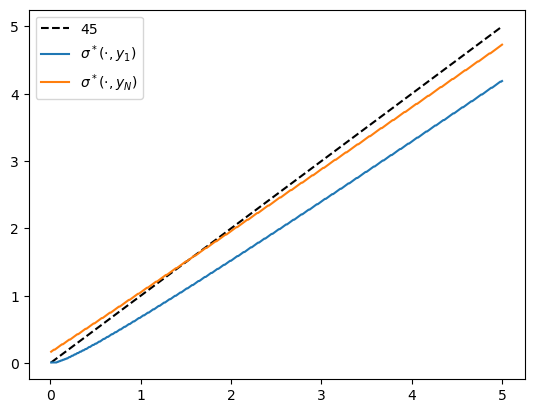

In [41]:
fig, ax = plt.subplots()
ax.plot(w_grid, w_grid, "k--", label="45")
ax.plot(w_grid, w_grid[σ_star_ez[:, 1]], label="$\\sigma^*(\cdot, y_1)$")
ax.plot(w_grid, w_grid[σ_star_ez[:, -1]], label="$\\sigma^*(\cdot, y_N)$")
ax.legend()
plt.show()